

## Journal used for the implemetation
Journal title: Time Series Forecasting Based on Deep Learning CNN-LSTM-GRU Model on Stock Prices

Authors: Ghani Rizky Naufal, Antoni Wibowo

Journal Name: Time Series Forecasting Based on Deep Learning CNN-LSTM-GRU Model on Stock Prices

Year: 2023

# 1. Install and import the required libraries

In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install tensorflow

ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# 2. Load Data

## Dataset URL:
 https://www.kaggle.com/datasets/rohanrao/nifty50-stock-market-data

### Content
The data is the price history and trading volumes of the fifty stocks in the index NIFTY 50 from NSE (National Stock Exchange) India. All datasets are at a day-level with pricing and trading values split across .cvs files for each stock along with a metadata file with some macro-information about the stocks itself. The data spans from 1st January, 2000 to 30th April, 2021.

In the current project we've used the ADANI Ports Stock Data

In [4]:
from google.colab import files
uploaded = files.upload()

Saving ADANIPORTS.csv to ADANIPORTS.csv


# 3. Data Preparation


In [5]:
# Load dataset
df = pd.read_csv("ADANIPORTS.csv")

In [10]:
# Display the first few rows of the dataset
print("Preview of the dataset:")
print(df.head())

# Select 'Close' price column for forecasting
data = df[['Close']].values

# Normalize data to range [0, 1] using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create sequences for time series models
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Define the number of previous days to look at (sliding window)
SEQ_LENGTH = 60  # Using the past 60 days to predict the next one

# Create input-output sequences
X, y = create_sequences(data_scaled, SEQ_LENGTH)

# Split data: 80% for training, 20% for testing
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Further split training data: 70% train, 10% validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.125, random_state=42
)

# Print data shapes to verify
print("\nDataset shapes:")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val   shape: {X_val.shape},   y_val shape: {y_val.shape}")
print(f"X_test  shape: {X_test.shape},  y_test shape: {y_test.shape}")

# Save the processed arrays for model training
np.save("X_train.npy", X_train)
np.save("X_val.npy",   X_val)
np.save("X_test.npy",  X_test)
np.save("y_train.npy", y_train)
np.save("y_val.npy",   y_val)
np.save("y_test.npy",  y_test)

# Confirmation message
print("\nPreprocessing complete! Data is ready for deep learning models.")

Preview of the dataset:
         Date      Symbol Series  Prev Close    Open     High    Low   Last  \
0  2007-11-27  MUNDRAPORT     EQ      440.00  770.00  1050.00  770.0  959.0   
1  2007-11-28  MUNDRAPORT     EQ      962.90  984.00   990.00  874.0  885.0   
2  2007-11-29  MUNDRAPORT     EQ      893.90  909.00   914.75  841.0  887.0   
3  2007-11-30  MUNDRAPORT     EQ      884.20  890.00   958.00  890.0  929.0   
4  2007-12-03  MUNDRAPORT     EQ      921.55  939.75   995.00  922.0  980.0   

    Close    VWAP    Volume      Turnover  Trades  Deliverable Volume  \
0  962.90  984.72  27294366  2.687719e+15     NaN             9859619   
1  893.90  941.38   4581338  4.312765e+14     NaN             1453278   
2  884.20  888.09   5124121  4.550658e+14     NaN             1069678   
3  921.55  929.17   4609762  4.283257e+14     NaN             1260913   
4  969.30  965.65   2977470  2.875200e+14     NaN              816123   

   %Deliverble  
0       0.3612  
1       0.3172  
2       0.2

## 4. Deep Neural Network Architecture

## 4.1 Design the architecture

In [11]:
# Select 'Close' price and normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Close']].values)

In [12]:
# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 60
X, y = create_sequences(data_scaled, SEQ_LENGTH)

In [13]:
# Define model
model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(SEQ_LENGTH, 1)),
    LSTM(64, return_sequences=True),
    GRU(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# Compile model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# 4.2 DNN Report

In [16]:
# Display model summary to report the number of layers, units, and parameters
model.summary()

# Extract and report model parameters
total_params = model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])

print(f"Total Parameters: {total_params}")
print(f"Trainable Parameters: {trainable_params}")
print(f"Non-Trainable Parameters: {non_trainable_params}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 58, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,353 (235.75 KB)

 Trainable params: 60,353 (235.75 KB)

 Non-trainable params: 0 (0.00 B)

Total Parameters: 60353
Trainable Parameters: 60353
Non-Trainable Parameters: 0


# 5. Training the model

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - loss: 0.0118 - mae: 0.0696 - val_loss: 0.0010 - val_mae: 0.0221
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - loss: 0.0022 - mae: 0.0285 - val_loss: 7.2495e-04 - val_mae: 0.0183
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0023 - mae: 0.0283 - val_loss: 0.0011 - val_mae: 0.0253
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.0018 - mae: 0.0268 - val_loss: 4.2977e-04 - val_mae: 0.0144
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - loss: 0.0015 - mae: 0.0239 - val_loss: 2.3787e-04 - val_mae: 0.0107
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - loss: 0.0015 - mae: 0.0232 - val_loss: 2.7005e-04 - val_mae: 0.0112
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.0017 - mae: 0.0241 - val_loss: 2.6575e-04 - val_mae: 0.0109
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - loss: 0.0014 - mae: 0.0233 - val_loss: 2.1459e-04 - val_mae: 0.0098
Epoch 9/10
72/72 ━━━━━━━━━━━━━━━━━

In [18]:
print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [19]:
model.fit(X_train, y_train, epochs=50, batch_size=16, validation_data=(X_test, y_test))

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 12s 84ms/step - loss: 0.0011 - mae: 0.0219 - val_loss: 2.6063e-04 - val_mae: 0.0138
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 18s 68ms/step - loss: 9.5635e-04 - mae: 0.0210 - val_loss: 1.3774e-04 - val_mae: 0.0090
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 0.0011 - mae: 0.0225 - val_loss: 9.9148e-05 - val_mae: 0.0066
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 0.0012 - mae: 0.0210 - val_loss: 5.7847e-04 - val_mae: 0.0210
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - loss: 0.0011 - mae: 0.0198 - val_loss: 2.0766e-04 - val_mae: 0.0096
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 69ms/step - loss: 7.4820e-04 - mae: 0.0181 - val_loss: 1.2538e-04 - val_mae: 0.0086
Epoch 7/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 9.1161e-04 - mae: 0.0201 - val_loss: 6.9600e-04 - val_mae: 0.0248
Epoch 8/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 9.3871e-04 - mae: 0.0212 - val_loss: 1.4436e-04 - val_mae: 0

# 6. Test the model

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Make predictions
y_pred = model.predict(X_test)

# Convert predictions back to actual prices
y_pred_actual = scaler.inverse_transform(y_pred)
y_test_actual = scaler.inverse_transform(y_test)

# Calculate performance metrics
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred_actual))

print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
Test MAE: 8.764599165397987
Test RMSE: 12.925899318126351


# 7. Report the result

### Plot Actual vs Predicted Prices

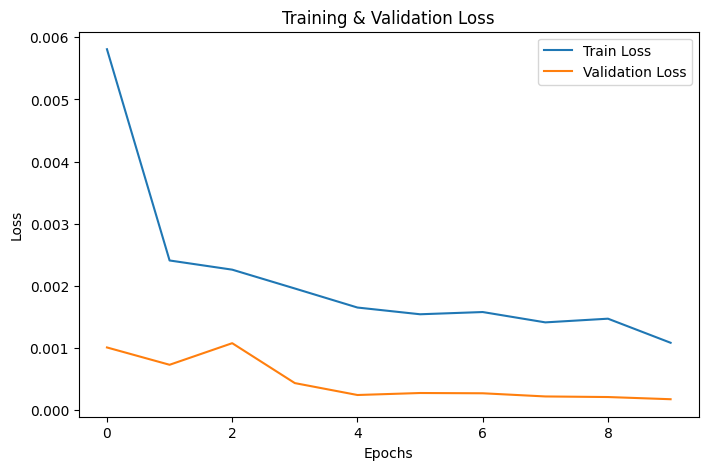

In [21]:
import matplotlib.pyplot as plt

# 1. Plot training & validation loss history
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

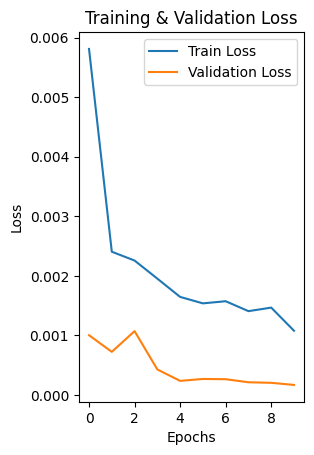

In [22]:
# 2. Plot training & validation loss history
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

In [23]:
# 3. Report testing accuracy and loss
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 0.73%
Test Loss: 0.0001


21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step


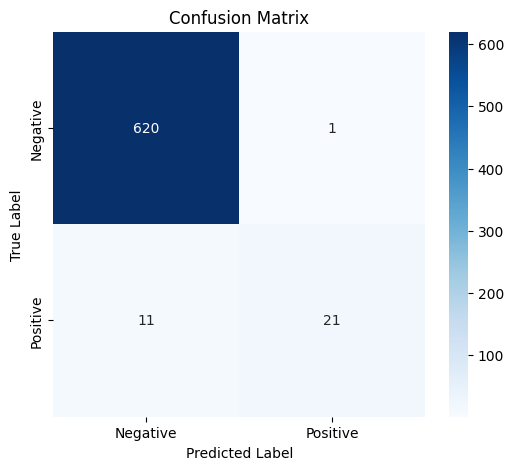

In [26]:
# 4. Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


y_pred_classes = (model.predict(X_test) > 0.5).astype("int32")
y_test_classes = (y_test > 0.5).astype("int32")

conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [28]:
# 5. Report values for performance study metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='binary')
recall = recall_score(y_test_classes, y_pred_classes, average='binary')
f1 = f1_score(y_test_classes, y_pred_classes, average='binary')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.9816
Precision: 0.9545
Recall: 0.6562
F1 Score: 0.7778


### Make Future Predictions

In [29]:
# Use the last 60 days of data for prediction
latest_data = data_scaled[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)

# Predict future price
future_price_scaled = model.predict(latest_data)
future_price = scaler.inverse_transform(future_price_scaled)

print(f"Predicted Next Day Price: {future_price[0][0]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Predicted Next Day Price: 708.1376953125
